Import the libraries

In [1]:
import pickle
import matplotlib.pyplot as plt
import os
import scikit_posthocs as sp
import scipy.stats as ss

Getting the results

In [2]:
# Paths to the pickle files
Base_path = '../Results/Base_Results.pkl'
BigFeat_path = '../Results/BigFeat_results.pkl'
AutoFeat_path = '../Results/AutoFeat_results.pkl'
FT_path = '../Results/FT_Results.pkl'
Open_path = '../Results/OpenFE_Results.pkl'
SAFE_path = '../Results/SAFE_Results.pkl'

# Load the data
with open(Base_path, 'rb') as f:
    Base = pickle.load(f)

with open(BigFeat_path, 'rb') as f:
    BigFeat = pickle.load(f)

with open(AutoFeat_path, 'rb') as f:
    AutoFeat = pickle.load(f)

with open(FT_path, 'rb') as f:
    FeatureTools = pickle.load(f)

with open(Open_path, 'rb') as f:
    OpenFE = pickle.load(f)

with open(SAFE_path, 'rb') as f:
    SAFE = pickle.load(f)

### Finding the best ML model for SAFE

Checking if there is a difference between model performance

In [3]:

def perform_friedman_test(dataframe, model_col, metric):
    """
    Performs the Friedman test on scores extracted from the specified metric column, grouped by models,
    and provides an interpretation of the results.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data.
    - model_col (str): The name of the column in the DataFrame that identifies the model.
    - metric (str): The name of the metric column for which the Friedman test is to be performed.

    Returns:
    - dict: A dictionary containing the Friedman test statistic, p-value, and interpretation of the results.
    """
    # Extract scores for each model from the dataframe
    score_data = [group[metric].values for _, group in dataframe.groupby(model_col)]

    # Perform the Friedman test on the extracted scores
    friedman_result = ss.friedmanchisquare(*score_data)

    # Interpret the results
    alpha = 0.05  # typical value for statistical significance
    if friedman_result.pvalue < alpha:
        interpretation = 'There is  evidence that the performance of the models is significantly different.'
    else:
        interpretation = 'There is no evidence that the performance of the models is significantly different.'

    # Create result dictionary
    result = {
        'Statistic': friedman_result.statistic,
        'P-value': friedman_result.pvalue,
        'Interpretation': interpretation
    }

    return result


Classification Scenario

In [4]:
for metric in ['Accuracy','F1']:
    print(f'The metric is: {metric}')
    result = perform_friedman_test(Base['classification_df'], 'Model', metric)
    print(result)

The metric is: Accuracy
{'Statistic': np.float64(45.70414472177698), 'P-value': np.float64(1.6225038627375929e-06), 'Interpretation': 'There is  evidence that the performance of the models is significantly different.'}
The metric is: F1
{'Statistic': np.float64(48.1412300683371), 'P-value': np.float64(5.848812208976221e-07), 'Interpretation': 'There is  evidence that the performance of the models is significantly different.'}


Regression Scenario

In [5]:
for metric in ['NMAE','R2']:
    print(f'The metric is: {metric}')
    result = perform_friedman_test(Base['regression_df'], 'Model', metric)
    print(result)

The metric is: NMAE
{'Statistic': np.float64(101.70909090909083), 'P-value': np.float64(2.4778842835721327e-17), 'Interpretation': 'There is  evidence that the performance of the models is significantly different.'}
The metric is: R2
{'Statistic': np.float64(93.0727272727272), 'P-value': np.float64(1.3139876599239275e-15), 'Interpretation': 'There is  evidence that the performance of the models is significantly different.'}


Plotting the critical difference diagrams for each case

In [6]:
def plot_critical_difference(dataframe, model_col, run_col, metric, name):
    """
    Generates a critical difference diagram for the specified metric across different models and runs.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data.
    - model_col (str): The name of the column in the DataFrame that identifies the model.
    - run_col (str): The name of the column in the DataFrame that identifies the run or dataset evaluation.
    - metric (str): The name of the metric column for which the critical difference is to be computed.
    - name (str): The name in which the figure should be stored

    Returns:
    - matplotlib.pyplot.Figure: The critical difference diagram plotted as a figure.
    """
    # Set all font sizes to 12
    plt.rcParams.update({'font.size': 12})
    
    # Calculate average ranks of the metric across runs for each model
    avg_rank = dataframe.groupby(run_col)[metric].rank(pct=False, ascending=False).groupby(dataframe[model_col]).mean()

    # Perform the Nemenyi Friedman test
    test_results = sp.posthoc_nemenyi_friedman(
        dataframe.sort_values(by=[run_col, model_col]),
        melted=True,
        block_col=run_col,
        group_col=model_col,
        y_col=metric,
    )

    # Create the plot
    plt.figure(figsize=(10, 2), dpi=100)
    sp.critical_difference_diagram(
        ranks=avg_rank,
        sig_matrix=test_results + 0.000001,  # Small increment to avoid precision issues
        label_fmt_left='{label} [{rank:.3f}]  ',
        label_fmt_right='  [{rank:.3f}] {label}',
        text_h_margin=0.3,
        label_props={'color': 'black', 'fontweight': 'bold'},
        crossbar_props={'color': None, 'marker': 'o'},
        marker_props={'marker': '*', 's': 150, 'color': 'y', 'edgecolor': 'k'},
        elbow_props={'color': 'gray'},
    )
    # Save the figure as PDF
    plt.savefig(f"../Diagrams/{name}.pdf")
    plt.show()

Classification Scenario

c:\Users\25644574\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


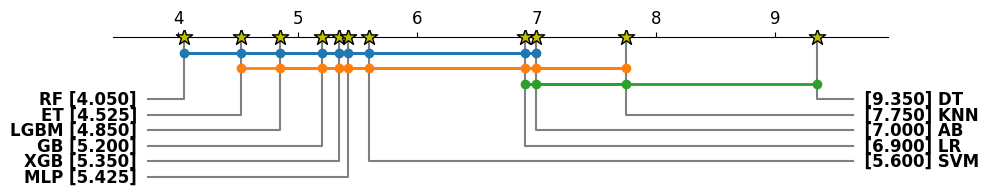

In [7]:
plot_critical_difference(Base['classification_df'], 'Model', 'Dataframe', 'Accuracy','fig3')

c:\Users\25644574\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


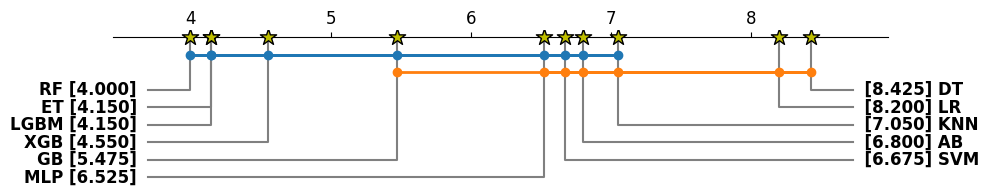

In [8]:
plot_critical_difference(Base['classification_df'], 'Model', 'Dataframe', 'F1','fig4')

Regression Scenario

c:\Users\25644574\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


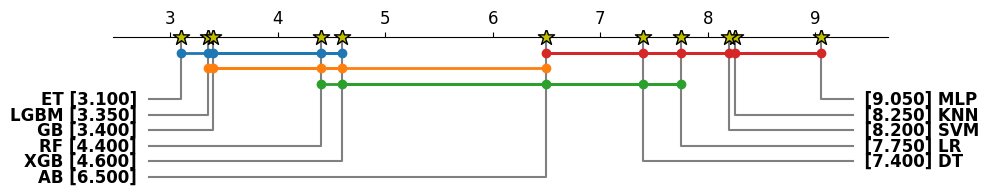

In [9]:
for metric in ['R2']:
    plot_critical_difference(Base['regression_df'], 'Model', 'Dataframe', metric,'fig5')

Reverse the order for NMAE

In [10]:
def plot_critical_difference(dataframe, model_col, run_col, metric, name):
    """
    Generates a critical difference diagram for the specified metric across different models and runs.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data.
    - model_col (str): The name of the column in the DataFrame that identifies the model.
    - run_col (str): The name of the column in the DataFrame that identifies the run or dataset evaluation.
    - metric (str): The name of the metric column for which the critical difference is to be computed.
    - name (str): The name in which the figure should be stored

    Returns:
    - matplotlib.pyplot.Figure: The critical difference diagram plotted as a figure.
    """
    # Set all font sizes to 12
    plt.rcParams.update({'font.size': 12})
    
    # Calculate average ranks of the metric across runs for each model
    avg_rank = dataframe.groupby(run_col)[metric].rank(pct=False).groupby(dataframe[model_col]).mean()

    # Perform the Nemenyi Friedman test
    test_results = sp.posthoc_nemenyi_friedman(
        dataframe.sort_values(by=[run_col, model_col]),
        melted=True,
        block_col=run_col,
        group_col=model_col,
        y_col=metric,
    )

    # Create the plot
    plt.figure(figsize=(10, 2), dpi=100)
    sp.critical_difference_diagram(
        ranks=avg_rank,
        sig_matrix=test_results + 0.000001,  # Small increment to avoid precision issues
        label_fmt_left='{label} [{rank:.3f}]  ',
        label_fmt_right='  [{rank:.3f}] {label}',
        text_h_margin=0.3,
        label_props={'color': 'black', 'fontweight': 'bold'},
        crossbar_props={'color': None, 'marker': 'o'},
        marker_props={'marker': '*', 's': 150, 'color': 'y', 'edgecolor': 'k'},
        elbow_props={'color': 'gray'},
    )
    # Save the figure as PDF
    plt.savefig(f"../Diagrams/{name}.pdf")
    plt.show()

c:\Users\25644574\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


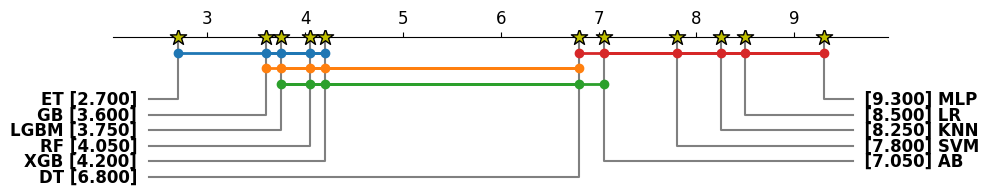

In [11]:
for metric in ['NMAE']:
    plot_critical_difference(Base['regression_df'], 'Model', 'Dataframe', metric,'fig6')